In [1]:
# coding=utf-8
import pandas as pd
# 用来显示图片的工具包
from IPython.display import Image
# 实现在内存缓冲区中读写数据
from six import StringIO
# 引入模型评价函数
from sklearn import model_selection, tree, metrics
# 引入决策树模型
from sklearn.tree import DecisionTreeClassifier
# 生成图表
import pydotplus

# 数据读入

In [2]:
credit = pd.read_csv("./input/credit.csv")
print(credit.shape)
credit.head(10)

(1000, 21)


,checking_balance,months_loan_duration,credit_history,purpose,amount,savings_balance,employment_length,installment_rate,personal_status,other_debtors,...,property,age,installment_plan,housing,existing_credits,job,dependents,telephone,foreign_worker,default
0,< 0 DM,6,critical,radio/tv,1169,unknown,> 7 yrs,4,single male,none,...,real estate,67,none,own,2,skilled employee,1,yes,yes,1
1,1 - 200 DM,48,repaid,radio/tv,5951,< 100 DM,1 - 4 yrs,2,female,none,...,real estate,22,none,own,1,skilled employee,1,none,yes,2
2,unknown,12,critical,education,2096,< 100 DM,4 - 7 yrs,2,single male,none,...,real estate,49,none,own,1,unskilled resident,2,none,yes,1
3,< 0 DM,42,repaid,furniture,7882,< 100 DM,4 - 7 yrs,2,single male,guarantor,...,building society savings,45,none,for free,1,skilled employee,2,none,yes,1
4,< 0 DM,24,delayed,car (new),4870,< 100 DM,1 - 4 yrs,3,single male,none,...,unknown/none,53,none,for free,2,skilled employee,2,none,yes,2
5,unknown,36,repaid,education,9055,unknown,1 - 4 yrs,2,single male,none,...,unknown/none,35,none,for free,1,unskilled resident,2,yes,yes,1
6,unknown,24,repaid,furniture,2835,501 - 1000 DM,> 7 yrs,3,single male,none,...,building society savings,53,none,own,1,skilled employee,1,none,yes,1
7,1 - 200 DM,36,repaid,car (used),6948,< 100 DM,1 - 4 yrs,2,single male,none,...,other,35,none,rent,1,mangement self-employed,1,yes,yes,1
8,unknown,12,repaid,radio/tv,3059,> 1000 DM,4 - 7 yrs,2,divorced male,none,...,real estate,61,none,own,1,unskilled resident,1,none,yes,1
9,1 - 200 DM,30,critical,car (new),5234,< 100 DM,unemployed,4,married male,none,...,other,28,none,own,2,mangement self-employed,1,none,yes,2


# 数据预处理
## 查看数据特点

In [3]:
# 查看支票余额属性各个取值的分布
credit["checking_balance"].value_counts()

checking_balance
unknown       394
< 0 DM        274
1 - 200 DM    269
> 200 DM       63
Name: count, dtype: int64

In [4]:
# 查看储蓄账户余额的分布
credit["savings_balance"].value_counts()

savings_balance
< 100 DM         603
unknown          183
101 - 500 DM     103
501 - 1000 DM     63
> 1000 DM         48
Name: count, dtype: int64

In [5]:
# 查看贷款期限和贷款申请额度的分布情况
credit["months_loan_duration"].value_counts()

months_loan_duration
24    184
12    179
18    113
36     83
6      75
15     64
9      49
48     48
30     40
21     30
10     28
60     13
27     13
42     11
11      9
20      8
8       7
4       6
45      5
7       5
39      5
14      4
13      4
33      3
28      3
54      2
16      2
22      2
47      1
5       1
26      1
72      1
40      1
Name: count, dtype: int64

In [6]:
# 获取贷款期限和贷款申请额度的中位数
# 贷款期限
credit["months_loan_duration"].median()

18.0

In [7]:
# 获取贷款期限和贷款申请额度的中位数
# 贷款申请额度
credit["amount"].value_counts().median()

1.0

In [8]:
# 查看数据集中违约和非违约样本的数量。
credit["default"].value_counts()

default
1    700
2    300
Name: count, dtype: int64

## 数据编码

In [9]:
# 创建编码所用的数据字典
col_dicts = {}

In [10]:
# 获取编码的属性集
for col_name in credit.columns:
    col_data = credit[col_name]
    # print(col_name,credit[col_name].dtype)
    if str(credit[col_name].dtype) != "int64":
        new_dict = {}
        cnt = 0
        # 定义编码规则
        for var in credit[col_name].unique():
            new_dict[str(var)] = cnt
            cnt += 1
        col_dicts[col_name] = new_dict
col_dicts

{'checking_balance': {'< 0 DM': 0,
  '1 - 200 DM': 1,
  'unknown': 2,
  '> 200 DM': 3},
 'credit_history': {'critical': 0,
  'repaid': 1,
  'delayed': 2,
  'fully repaid': 3,
  'fully repaid this bank': 4},
 'purpose': {'radio/tv': 0,
  'education': 1,
  'furniture': 2,
  'car (new)': 3,
  'car (used)': 4,
  'business': 5,
  'domestic appliances': 6,
  'repairs': 7,
  'others': 8,
  'retraining': 9},
 'savings_balance': {'unknown': 0,
  '< 100 DM': 1,
  '501 - 1000 DM': 2,
  '> 1000 DM': 3,
  '101 - 500 DM': 4},
 'employment_length': {'> 7 yrs': 0,
  '1 - 4 yrs': 1,
  '4 - 7 yrs': 2,
  'unemployed': 3,
  '0 - 1 yrs': 4},
 'personal_status': {'single male': 0,
  'female': 1,
  'divorced male': 2,
  'married male': 3},
 'other_debtors': {'none': 0, 'guarantor': 1, 'co-applicant': 2},
 'property': {'real estate': 0,
  'building society savings': 1,
  'unknown/none': 2,
  'other': 3},
 'installment_plan': {'none': 0, 'bank': 1, 'stores': 2},
 'housing': {'own': 0, 'for free': 1, 'rent': 2}

In [11]:
# 执行编码
for col in col_dicts.keys():
    credit[col] = credit[col].map(col_dicts[col])

In [12]:
# 查看编码，输出前五行数据
credit.head(5)

,checking_balance,months_loan_duration,credit_history,purpose,amount,savings_balance,employment_length,installment_rate,personal_status,other_debtors,...,property,age,installment_plan,housing,existing_credits,job,dependents,telephone,foreign_worker,default
0,0,6,0,0,1169,0,0,4,0,0,...,0,67,0,0,2,0,1,0,0,1
1,1,48,1,0,5951,1,1,2,1,0,...,0,22,0,0,1,0,1,1,0,2
2,2,12,0,1,2096,1,2,2,0,0,...,0,49,0,0,1,1,2,1,0,1
3,0,42,1,2,7882,1,2,2,0,1,...,1,45,0,1,1,0,2,1,0,1
4,0,24,2,3,4870,1,1,3,0,0,...,2,53,0,1,2,0,2,1,0,2


## 划分数据集

In [13]:
# 确定因变量
y = credit['default']
# 确定自变量
X = credit.loc[:, 'checking_balance':'foreign_worker']
# 划分训练集和测试集，random_state=1表示先打乱顺序再划分，测试集占比30%
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=1)
# 验证训练集和测试集中，违约贷款的比例是否接近。
# 查看训练集中违约和非违约样本的分布
y_train.value_counts() / len(y_train)
# 查看测试集中违约和非违约样本的分布
y_test.value_counts() / len(y_test)

default
1    0.713333
2    0.286667
Name: count, dtype: float64

# 模型构建和训练

In [14]:
DecisionTreeClassifier(criterion="gini",
                       splitter="best",
                       max_depth=None,
                       min_samples_split=2,
                       min_samples_leaf=1,
                       min_weight_fraction_leaf=0.,
                       max_features=None,
                       random_state=None,
                       max_leaf_nodes=None,
                       min_impurity_decrease=0.,
                       # min_impurity_split=None,
                       class_weight=None,
                       # presort=False
                       )

DecisionTreeClassifier()

In [15]:
# 创建模型
# min_samples_leaf可以为整数或者浮点数，默认为1。它指定了每个叶子节点包含的最少样本数。
# 如果为浮点数(0到1之间)，每个叶子节点包含的最少样本数为ceil(min_samples_leaf * n_samples)
credit_model = DecisionTreeClassifier(min_samples_leaf=6, random_state=1)
# 训练模型
credit_model.fit(X_train, y_train)

DecisionTreeClassifier(min_samples_leaf=6, random_state=1)

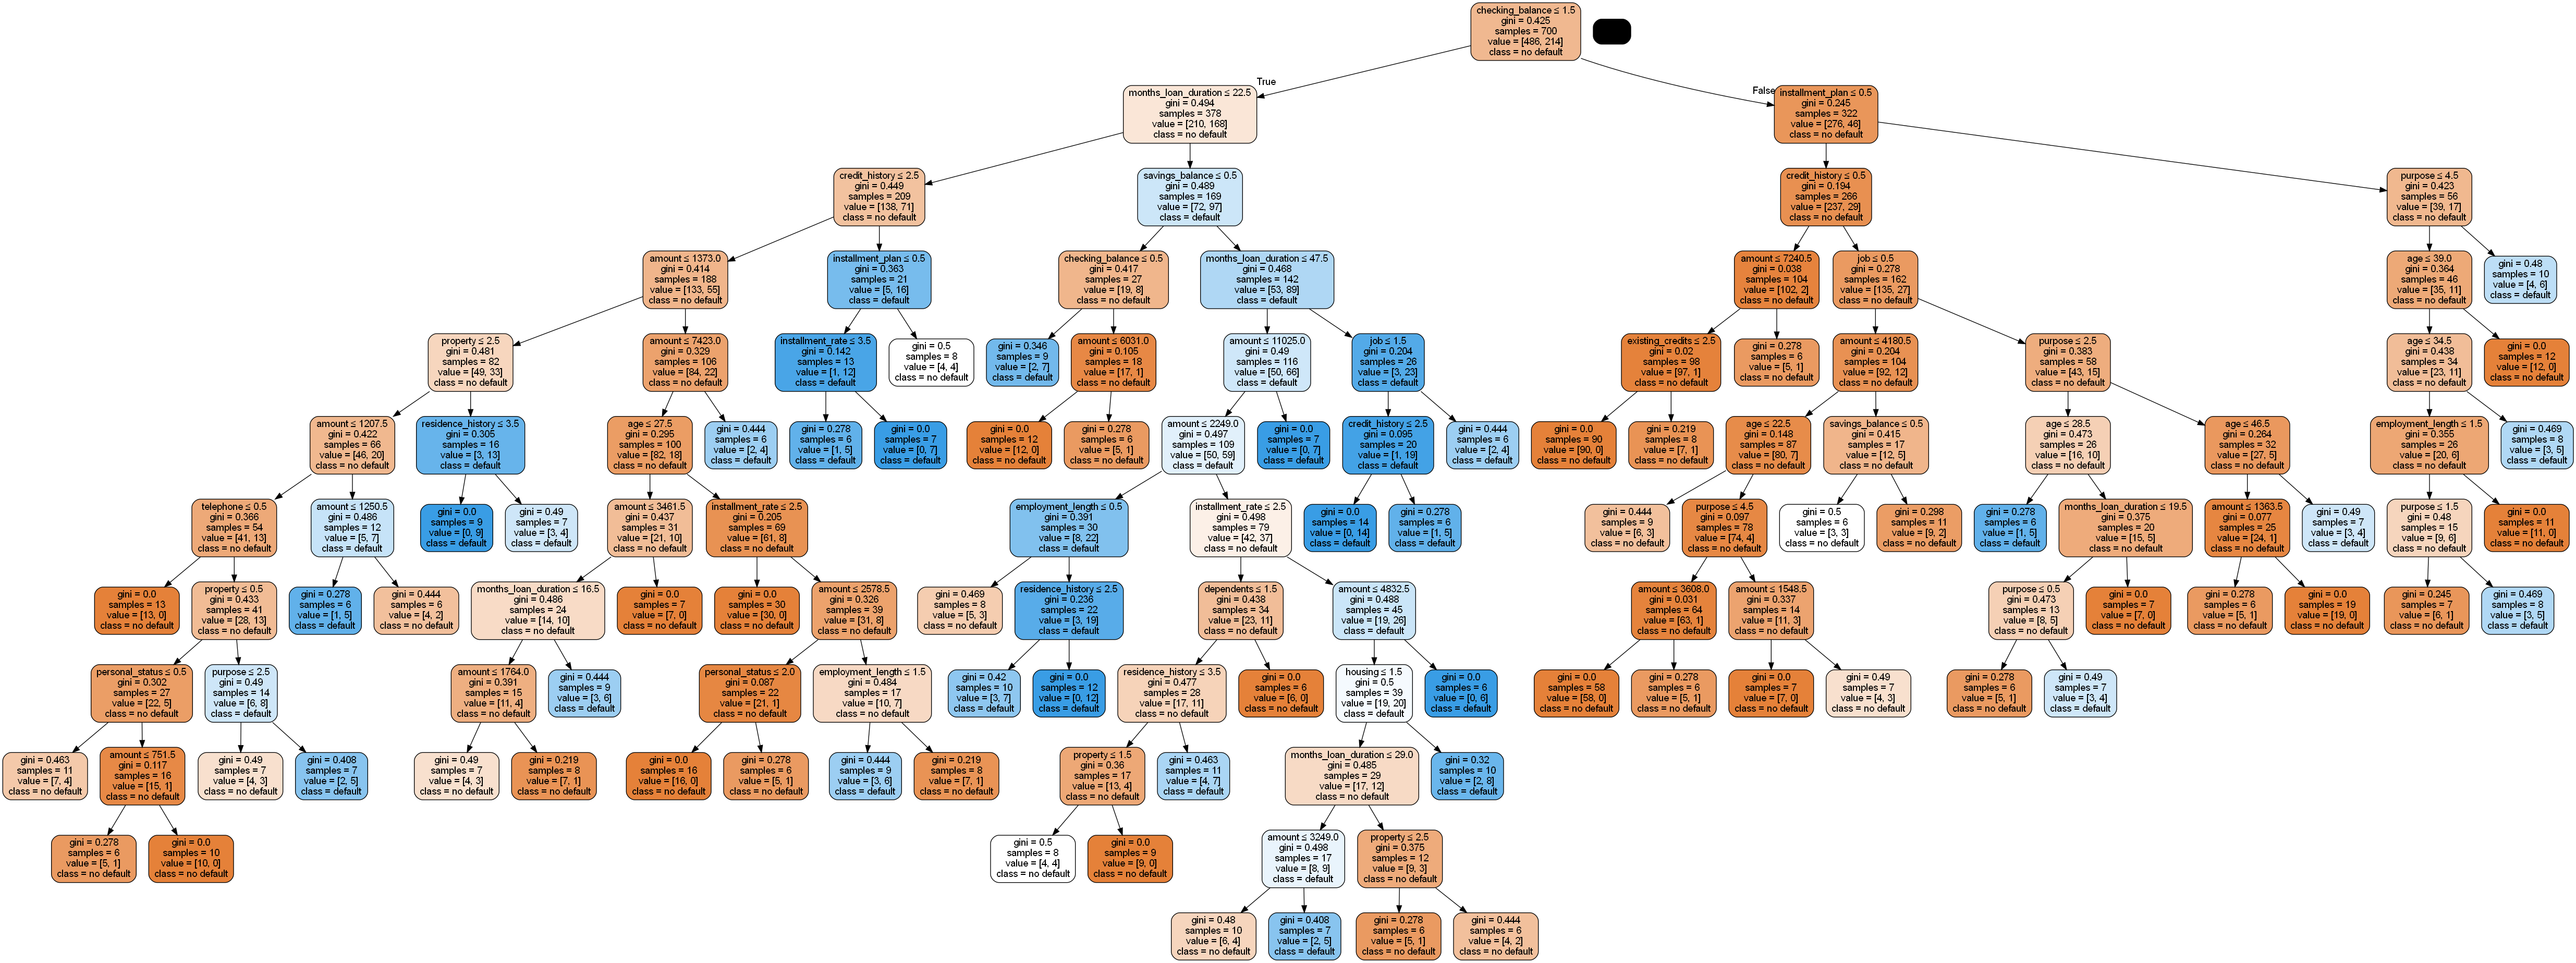

In [16]:
# 获取决策树的数据
dot_data = StringIO()
# 决策树构建
tree.export_graphviz(credit_model, out_file=dot_data,
                     feature_names=X_train.columns,
                     class_names=['no default', 'default'],
                     filled=True, rounded=True,
                     special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [17]:
# 保存图片到本地
graph.write_png('./output/creditAssess.png')

True

# 性能评估

In [18]:
# 推测测试集标签
credit_pred = credit_model.predict(X_test)
# 绘制混淆矩阵
metrics.confusion_matrix(y_test, credit_pred)

array([[175,  39],
       [ 44,  42]], dtype=int64)

In [19]:
# 显示主要分类指标的文本报告．在报告中显示每个类的精确度，召回率，F1值等信息。
print(metrics.classification_report(y_test, credit_pred))

              precision    recall  f1-score   support

           1       0.80      0.82      0.81       214
           2       0.52      0.49      0.50        86

    accuracy                           0.72       300
   macro avg       0.66      0.65      0.66       300
weighted avg       0.72      0.72      0.72       300



# 性能提升

In [20]:
# 认为一个贷款违约者给银行带来的损失是银行错过一个不违约的贷款带来损失的4倍
class_weights = {1: 1, 2: 4}
credit_model_cost = DecisionTreeClassifier(max_depth=6, class_weight=class_weights)
credit_model_cost.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={1: 1, 2: 4}, max_depth=6)

In [21]:
credit_pred_cost = credit_model_cost.predict(X_test)

In [22]:
metrics.classification_report(y_test, credit_pred_cost)

'              precision    recall  f1-score   support\n\n           1       0.88      0.56      0.68       214\n           2       0.42      0.81      0.56        86\n\n    accuracy                           0.63       300\n   macro avg       0.65      0.69      0.62       300\nweighted avg       0.75      0.63      0.65       300\n'

In [23]:
metrics.confusion_matrix(y_test, credit_pred_cost)

array([[119,  95],
       [ 16,  70]], dtype=int64)

In [24]:
metrics.accuracy_score(y_test, credit_pred_cost)

0.63